In [2]:
import cv2
import numpy as np
import os
import shutil
from tqdm import tqdm

# --- CRITICAL CONFIGURATION ---
# You MUST adjust this value based on your camera distance!
# Example: If a 10mm tape covers 200 pixels in your image, ratio is 10/200 = 0.05
MM_PER_PIXEL = 0.05  

def sort_cracks_by_mm(input_folder, output_base):
    # Define the new classes based on your screenshot
    # We use 'heavy' instead of 'large' to match your standard
    classes = ['light', 'medium', 'heavy']
    for c in classes:
        os.makedirs(os.path.join(output_base, c), exist_ok=True)
        
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    files = [f for f in os.listdir(input_folder) if f.lower().endswith(valid_extensions)]
    
    print(f"Sorting {len(files)} images based on Real-World Width (mm)...")
    print(f"Using conversion: 1 Pixel = {MM_PER_PIXEL} mm")
    
    count_light = 0
    count_medium = 0
    count_heavy = 0
    
    for filename in tqdm(files):
        img_path = os.path.join(input_folder, filename)
        
        # 1. Read Image (Grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        # 2. Extract Crack (Thresholding)
        # Inverts image so crack is WHITE, background is BLACK
        # Note: If your preprocessing (Phase 1) was good, cracks are dark.
        _, binary = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY_INV)
        
        # 3. Clean Noise (Morphology)
        # Remove tiny specs that are smaller than a real crack
        kernel = np.ones((3,3), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        # 4. Measure Max Width in Pixels
        dist_transform = cv2.distanceTransform(cleaned, cv2.DIST_L2, 5)
        
        if dist_transform.max() == 0:
            max_width_px = 0
        else:
            # Distance transform gives radius, so * 2 for diameter (width)
            max_width_px = dist_transform.max() * 2 
            
        # 5. Convert to Millimeters
        width_mm = max_width_px * MM_PER_PIXEL
        
        # 6. Apply Your Exact Standards
        if width_mm <= 0.1:
            category = 'light'
            count_light += 1
        elif width_mm <= 0.3:
            # Meaning > 0.1 and <= 0.3
            category = 'medium'
            count_medium += 1
        else:
            # Meaning > 0.3
            category = 'heavy'
            count_heavy += 1
            
        # 7. Move/Copy File
        shutil.copy(img_path, os.path.join(output_base, category, filename))

    print("\n--- Sorting Complete ---")
    print(f"Light  (<= 0.1mm): {count_light}")
    print(f"Medium (0.1-0.3mm): {count_medium}")
    print(f"Heavy  (> 0.3mm):  {count_heavy}")
    print(f"Check folder: {output_base}")

# --- RUN IT ---
# Input: Your folder of standardized/preprocessed patches
input_dir = 'dataset_standardized' 
output_dir = 'dataset_sorted_mm'

if os.path.exists(input_dir):
    sort_cracks_by_mm(input_dir, output_dir)
else:
    print(f"Error: {input_dir} not found. Please run Phase 1 preprocessing first.")

Sorting 17793 images based on Real-World Width (mm)...
Using conversion: 1 Pixel = 0.05 mm


100%|██████████| 17793/17793 [02:16<00:00, 130.42it/s]


--- Sorting Complete ---
Light  (<= 0.1mm): 250
Medium (0.1-0.3mm): 135
Heavy  (> 0.3mm):  17408
Check folder: dataset_sorted_mm


In [3]:
import os
import shutil
import random
from tqdm import tqdm

def undersample_dataset(dataset_path, backup_path):
    """
    Reduces the number of images in larger folders to match the smallest folder.
    Excess images are moved to 'backup_path' (not deleted permanently).
    """
    
    if not os.path.exists(dataset_path):
        print(f"Error: Folder '{dataset_path}' not found.")
        return

    # Create backup folder for the discarded images
    if not os.path.exists(backup_path):
        os.makedirs(backup_path)

    # 1. Identify classes and count images
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    class_counts = {}
    file_lists = {}
    
    print("Initial Counts:")
    for cls in classes:
        cls_dir = os.path.join(dataset_path, cls)
        # Get list of valid images
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[cls] = len(files)
        file_lists[cls] = files
        print(f"  - {cls}: {len(files)}")
        
    # Find the target number (the size of the SMALLEST folder)
    target_count = min(class_counts.values())
    print(f"\nTarget count (Smallest Class): {target_count}")
    print(f"All folders will be reduced to {target_count} images.")
    
    # 2. Undersample larger classes
    for cls in classes:
        current_count = class_counts[cls]
        
        if current_count <= target_count:
            print(f"Skipping '{cls}' (already at minimum size).")
            continue
            
        diff = current_count - target_count
        print(f"Downsampling '{cls}': Removing {diff} images...")
        
        # Create a specific backup folder for this class
        cls_backup_dir = os.path.join(backup_path, cls)
        os.makedirs(cls_backup_dir, exist_ok=True)
        
        # Randomly choose files to REMOVE
        # We assume the files we KEEP are random, so we pick 'diff' files to move away
        files_to_remove = random.sample(file_lists[cls], diff)
        
        for filename in tqdm(files_to_remove, desc=f"Moving {cls}"):
            src = os.path.join(dataset_path, cls, filename)
            dst = os.path.join(cls_backup_dir, filename)
            
            # Move the file out of the training set
            shutil.move(src, dst)
            
    print(f"\nSuccess! Dataset balanced. Unused images moved to '{backup_path}'.")

# --- CONFIGURATION ---
input_dir = 'dataset_sorted_mm'    # Your sorted dataset
unused_dir = 'dataset_unused_data' # Where extra images go (Safe storage)

undersample_dataset(input_dir, unused_dir)

Initial Counts:
  - heavy: 17408
  - light: 250
  - medium: 135

Target count (Smallest Class): 135
All folders will be reduced to 135 images.
Downsampling 'heavy': Removing 17273 images...


Moving heavy: 100%|██████████| 17273/17273 [00:11<00:00, 1473.85it/s]


Downsampling 'light': Removing 115 images...


Moving light: 100%|██████████| 115/115 [00:00<00:00, 1258.11it/s]

Skipping 'medium' (already at minimum size).

Success! Dataset balanced. Unused images moved to 'dataset_unused_data'.


In [11]:
import os
import shutil
import random
from tqdm import tqdm

def split_dataset(input_folder, output_folder, split_ratios=(0.7, 0.2, 0.1)):
    """
    Splits a sorted dataset into Train, Validation, and Test sets.
    
    input_folder:  Path to folder containing 'light', 'medium', 'large'
    output_folder: Path where 'train', 'val', 'test' folders will be created
    split_ratios:  (Train%, Val%, Test%) - must sum to 1.0
    """
    
    if sum(split_ratios) != 1.0:
        print("Error: Split ratios must sum to 1.0 (e.g., 0.7 + 0.2 + 0.1)")
        return

    # Define the classes based on what's in the input folder
    classes = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]
    
    print(f"Found classes: {classes}")
    
    # Create the output directories
    for split in ['train', 'val', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_folder, split, cls), exist_ok=True)
            
    # Process each class
    for cls in classes:
        cls_dir = os.path.join(input_folder, cls)
        images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Shuffle randomly so the split isn't biased
        random.shuffle(images)
        
        # Calculate split indices
        n_total = len(images)
        n_train = int(n_total * split_ratios[0])
        n_val = int(n_total * split_ratios[1])
        # The rest goes to test
        
        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]
        
        print(f"Class '{cls}': {len(train_imgs)} Train, {len(val_imgs)} Val, {len(test_imgs)} Test")
        
        # Helper function to copy files
        def copy_files(file_list, destination_split):
            for filename in file_list:
                src = os.path.join(cls_dir, filename)
                dst = os.path.join(output_folder, destination_split, cls, filename)
                shutil.copy(src, dst)

        # Execute copies
        copy_files(train_imgs, 'train')
        copy_files(val_imgs, 'val')
        copy_files(test_imgs, 'test')

    print(f"\nSuccess! Dataset split created in: {output_folder}")

# --- CONFIGURATION ---
# The folder created by the Auto-Sorter (contains light/medium/large)
source_data_dir = 'dataset_sorted_mm' 

# The NEW folder that will contain train/val/test
final_data_dir = 'dataset_final'

# Run the split
if os.path.exists(source_data_dir):
    split_dataset(source_data_dir, final_data_dir)
else:
    print(f"Could not find '{source_data_dir}'. Did you run the Auto-Sorter?")

Found classes: ['heavy', 'light', 'medium']
Class 'heavy': 94 Train, 27 Val, 14 Test
Class 'light': 175 Train, 50 Val, 25 Test
Class 'medium': 94 Train, 27 Val, 14 Test

Success! Dataset split created in: dataset_final


In [12]:
import os
import cv2
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import random

def augment_training_data(train_dir, multiplier=5):
    """
    Reads the training folder and generates 'multiplier' new versions of every image.
    args:
        train_dir: Path to dataset_final/train
        multiplier: How many new images to create per original (e.g., 5)
    """
    
    if not os.path.exists(train_dir):
        print(f"Error: Directory {train_dir} not found.")
        return

    # Define the augmentation pipeline
    # We use random choices so every generated image is slightly different
    augmenter = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomRotation(degrees=20), # Rotate +/- 20 degrees
        T.ColorJitter(brightness=0.2, contrast=0.2), # Simulate different lighting
        T.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Shift image slightly
    ])

    classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    print(f"Augmenting data in '{train_dir}' by {multiplier}x...")
    
    for cls in classes:
        class_path = os.path.join(train_dir, cls)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Filter out existing augmented images to avoid re-augmenting them
        # (Checks if filename already has '_aug_' in it)
        originals = [img for img in images if "_aug_" not in img]
        
        print(f"  Class '{cls}': Found {len(originals)} originals. Generating {len(originals) * multiplier} new images...")

        for img_name in tqdm(originals, desc=f"Processing {cls}"):
            img_path = os.path.join(class_path, img_name)
            
            # Load image using PIL (required for torchvision transforms)
            try:
                img = Image.open(img_path).convert('RGB')
            except:
                continue

            # Generate 'multiplier' copies
            for i in range(multiplier):
                # Apply transforms
                aug_img = augmenter(img)
                
                # Save with new name: "image_aug_0.jpg", "image_aug_1.jpg"
                base_name, ext = os.path.splitext(img_name)
                new_name = f"{base_name}_aug_{i}{ext}"
                save_path = os.path.join(class_path, new_name)
                
                aug_img.save(save_path)

    print("\nSuccess! Data augmentation complete.")

# --- CONFIGURATION ---
# Point this to your TRAIN folder only (Don't augment Test or Val!)
train_dataset_dir = 'dataset_final/train' 

# Run augmentation
# 5 means: 100 images becomes 600 (100 original + 500 new)
augment_training_data(train_dataset_dir, multiplier=5)

Augmenting data in 'dataset_final/train' by 5x...
  Class 'heavy': Found 118 originals. Generating 590 new images...


Processing heavy: 100%|██████████| 118/118 [00:13<00:00,  8.46it/s]


  Class 'light': Found 211 originals. Generating 1055 new images...


Processing light: 100%|██████████| 211/211 [00:23<00:00,  9.11it/s]


  Class 'medium': Found 120 originals. Generating 600 new images...


Processing medium: 100%|██████████| 120/120 [00:14<00:00,  8.46it/s]


Success! Data augmentation complete.


Using device: cuda
Classes found: ['heavy', 'light', 'medium']
Dataset sizes: {'train': 1692, 'val': 81}
Epoch 1/20
----------
train Loss: 0.8978 Acc: 0.5680
val Loss: 0.7365 Acc: 0.7037
-> Best model saved!

Epoch 2/20
----------
train Loss: 0.7773 Acc: 0.6436
val Loss: 0.6711 Acc: 0.7531
-> Best model saved!

Epoch 3/20
----------
train Loss: 0.7767 Acc: 0.6460
val Loss: 0.7419 Acc: 0.6667

Epoch 4/20
----------
train Loss: 0.7319 Acc: 0.6797
val Loss: 0.8012 Acc: 0.5926

Epoch 5/20
----------
train Loss: 0.7249 Acc: 0.6797
val Loss: 0.6404 Acc: 0.7778
-> Best model saved!

Epoch 6/20
----------
train Loss: 0.6988 Acc: 0.6950
val Loss: 0.6430 Acc: 0.7531

Epoch 7/20
----------
train Loss: 0.7142 Acc: 0.6939
val Loss: 0.6651 Acc: 0.7407

Epoch 8/20
----------
train Loss: 0.6918 Acc: 0.6891
val Loss: 0.6413 Acc: 0.7778

Epoch 9/20
----------
train Loss: 0.7107 Acc: 0.6732
val Loss: 0.6477 Acc: 0.7654

Epoch 10/20
----------
train Loss: 0.6948 Acc: 0.6944
val Loss: 0.6244 Acc: 0.7778

E

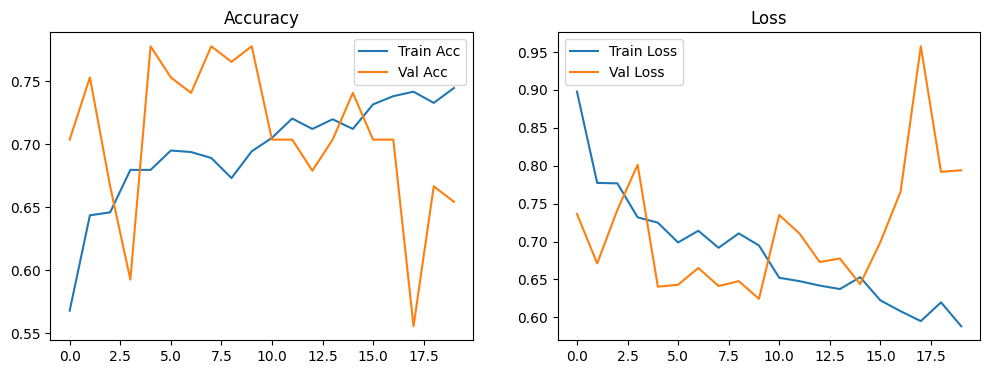

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import time
import copy
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
DATA_DIR = 'dataset_final'  # Root folder with train/val/test
NUM_CLASSES = 3             # light, medium, large
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

# --- 2. DATA TRANSFORMS ---
# We must resize to 224x224 for MobileNetV2 and normalize to ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        # Normalize with ImageNet mean/std (required for transfer learning)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- 3. DATA LOADERS ---
def get_data_loaders(data_dir):
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']}
    
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
                   for x in ['train', 'val']}
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names

# Check if data exists before running
if not os.path.exists(os.path.join(DATA_DIR, 'train')):
    raise FileNotFoundError(f"Could not find {DATA_DIR}/train. Did you run the split script?")

dataloaders, dataset_sizes, class_names = get_data_loaders(DATA_DIR)
print(f"Classes found: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# --- 4. MODEL SETUP (MobileNetV2) ---
def build_model(num_classes):
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    
    # Freeze the feature extraction layers (we don't want to retrain them yet)
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Replace the final classifier head
    # MobileNetV2 classifier is: Dropout -> Linear
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes) # Output layer (3 classes)
    )
    
    return model.to(DEVICE)

model = build_model(NUM_CLASSES)

# --- 5. OPTIMIZER & LOSS ---
criterion = nn.CrossEntropyLoss()
# Only optimize parameters that require gradients (the classifier head)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# --- 6. TRAINING FUNCTION ---
def train_model(model, criterion, optimizer, num_epochs=20):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_bridge_model.pth')
                print("-> Best model saved!")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# --- 7. RUN TRAINING ---
trained_model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)

# --- 8. PLOT RESULTS ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

Loading model from best_bridge_model.pth...
Running predictions on Test Set...

TEST SET RESULTS
              precision    recall  f1-score   support

       heavy       0.71      0.86      0.77        14
       light       0.54      0.50      0.52        14
      medium       0.58      0.50      0.54        14

    accuracy                           0.62        42
   macro avg       0.61      0.62      0.61        42
weighted avg       0.61      0.62      0.61        42



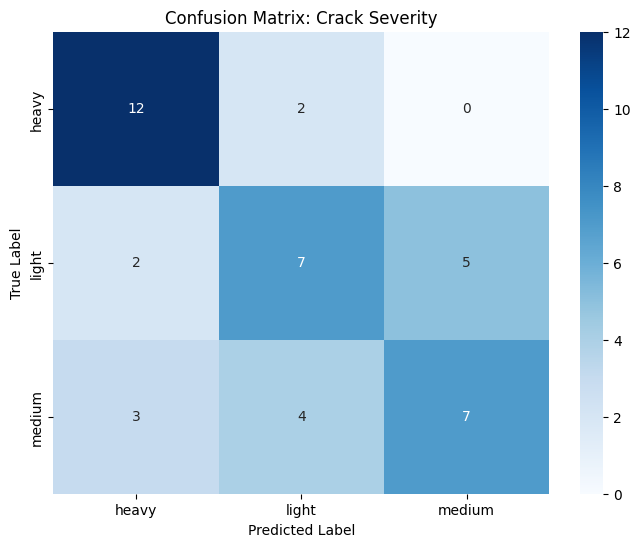

In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# --- CONFIGURATION ---
DATA_DIR = 'dataset_final'
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_PATH = 'best_bridge_model.pth' # The file saved during training
NUM_CLASSES = 3
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. REBUILD MODEL ARCHITECTURE ---
# We must define the exact same architecture to load the weights
def build_model(num_classes):
    model = models.mobilenet_v2(weights=None) # No need to download ImageNet weights again
    
    # Re-create the classifier head exactly as we did in training
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, num_classes)
    )
    return model

# --- 2. LOAD DATA ---
# Use the same transforms as Validation (Resize + Normalize only)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

if os.path.exists(TEST_DIR):
    test_dataset = datasets.ImageFolder(TEST_DIR, test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    class_names = test_dataset.classes # ['large', 'light', 'medium']
else:
    print(f"Error: {TEST_DIR} not found.")
    exit()

# --- 3. RUN PREDICTIONS ---
def evaluate_model():
    print(f"Loading model from {MODEL_PATH}...")
    model = build_model(NUM_CLASSES)
    
    # Load the trained weights
    # map_location ensures it loads on CPU if you trained on GPU but are now on CPU
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval() # Set to evaluation mode (turns off Dropout)

    all_preds = []
    all_labels = []

    print("Running predictions on Test Set...")
    with torch.no_grad(): # Disable gradient calculation for speed
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model()

# --- 4. GENERATE METRICS ---
print("\n" + "="*30)
print("TEST SET RESULTS")
print("="*30)

# Classification Report (Precision, Recall, F1-Score)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# --- 5. PLOT CONFUSION MATRIX ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Crack Severity')
plt.show()